# Editing a scene

## Overview

In this tutorial, you will learn how to modify a Mitsuba scene after it was loaded from a file on disk. As a user, you might want to slightly modify a scene before (re-)rendering it for many reasons. Maybe a color is slightly off, or an object should be moved a bit to the left. Thanskfully such trivial modifications can easily be applied from Python in Mitsuba 3 using what we call the *traverse mechanism*. Moreover, as we will see in later tutorials, this mechanism is essential for inverse rendering applications and more.

<div class="admonition important alert alert-block alert-info">

🚀 **What will you learn?**

<ul>
  <li>List exposed parameters of Mitsuba objects</li>
  <li>Modify a scene and update its internal state accordingly</li>
</ul>

</div>

## Load the scene

Following the same steps as in [Mitsuba Quickstart tutorial][1], let's import `mitsuba`, set the desired variant and load a scene from an XML file on disk.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/tutorials/getting_started/quickstart/rendering.html

In [1]:
import mitsuba as mi
mi.set_variant('scalar_rgb')

scene = mi.load_file("../../scenes/simple.xml")

Let's also quickly render this scene to know what we're exactly dealing with.

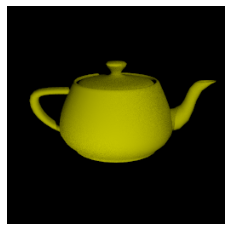

In [2]:
original_image = mi.render(scene, spp=128)

import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(original_image ** (1.0 / 2.2));

## Access scene parameters

Any Mitsuba object can be inspected using the [<code>traverse()</code>][1] function, which returns a instance of [<code>SceneParameters</code>][2]. It has a similar API to a Python `dict` and holds all parameters that are exposed by the input object and its children. Therefore, when given a scene as input, this function will return the parameters of all the objects present in the scene.

Let's gather the parameters of our scene and print it to look at the keys of the various parameters available in our scene graph.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SceneParameters

In [3]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type            Parent
  ----------------------------------------------------------------------------------------
  sensor.near_clip                              float           PerspectiveCamera
  sensor.far_clip                               float           PerspectiveCamera
  sensor.shutter_open                           float           PerspectiveCamera
  sensor.shutter_open_time                      float           PerspectiveCamera
  sensor.x_fov                                  float           PerspectiveCamera
  sensor.to_world                               Transform4f     PerspectiveCamera
  teapot.bsdf.reflectance.value        ∂        Color3f         SRGBReflectanceSpectrum
  teapot.vertex_count                           int             PLYMesh
  teapot.face_count                             int             PLYMesh
  teap

As you can see, the first level of our scene graph is composed of 4 objects: 

- the camera (`sensor`)
- the teapot mesh (`teapot`)
- two light sources (`light1` and `light2`). 

Some of those objects point to nested child objects, like `teapot.bsdf`, etc.

The names of the objects in the scene graph are defined by the id of those objects in the scene file. Object's parameters such as `teapot.vertex_positions` or `sensor.far_clip` are documented in their respective parent's plugin documentation: e.g. [PLYMesh][1] and [PerspectiveCamera][2]. All of the plugins in the documentation list which of their parameters are exposed, as well as all of the input parameters they can take in the scene description. If you wish to modifiy a plugin's parameter, and that parameter is not exposed with `traverse`, you still have the option to modify the scene file directly. `traverse` is merely a convenience function that allows you to modify scene objects in-place, rather than reconstructing the entire scene.

Individual scene parameters can be accessed with the `__getitem__` operator, providing the `key` corresponding to the parameter. Let's read the values of a few of the scene parameters.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_shapes.html#ply-stanford-triangle-format-mesh-loader-ply
[2]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_sensors.html#perspective-pinhole-camera-perspective

In [4]:
print('sensor.near_clip:             ',  params['sensor.near_clip'])
print('teapot.bsdf.reflectance.value:',  params['teapot.bsdf.reflectance.value'])
print('light1.intensity.value:       ',  params['light1.intensity.value'])

sensor.near_clip:              0.009999999776482582
teapot.bsdf.reflectance.value: [0.8999999761581421, 0.8999999761581421, 0.0]
light1.intensity.value:        [100.0, 100.0, 100.0]


## Edit the scene

For the sake of this tutorial, let's simply tint the color of both light sources. Similarly to a Python `dict`, parameters can be modified in-place using the `__setitem__` operator. Internally, the `SceneParameters` object will record every update written to it. Once all updates are performed, it is necessary to call the `SceneParameters.update` method to properly apply the desired changes.

Certain objects might need to be notified if one or more of its children have been updated. Using `SceneParameters.update` will also propagate all updates through the dependency graph, and perform all necessary updates to the parent objects. For instance, a change to the vertex position buffer of a mesh in the scene will trigger the recomputation of the Embree/Optix BHV.

In [5]:
# Give a red tint to light1 and a green tint to light2
params['light1.intensity.value'] *= [1.5, 0.2, 0.2]
params['light2.intensity.value'] *= [0.2, 1.5, 0.2]

# Apply updates
params.update()

After rendering the scene again, we can easily compare the rendered images using `matplotlib`. 

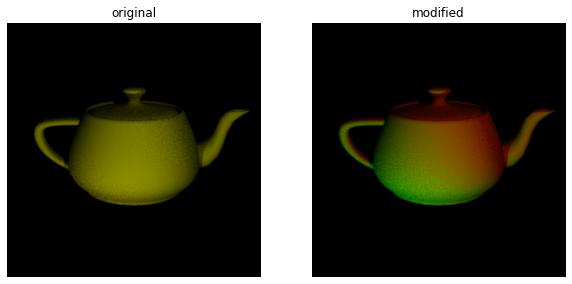

In [6]:
modified_image = mi.render(scene, spp=128)
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1).imshow(original_image); plt.axis('off'); plt.title('original')
fig.add_subplot(1,2,2).imshow(modified_image); plt.axis('off'); plt.title('modified');

## See also

- [<code>mitsuba.traverse()</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse)
- [<code>mitsuba.SceneParameters</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html##mitsuba.SceneParameters)